In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from colorama import Fore, Style
import xgboost
import lightgbm
import catboost
import os
import datetime
import pickle
import warnings
import umap
import statsmodels.api as sm

In [ ]:
from sklearn.base import clone
from sklearn.model_selection import KFold, StratifiedKFold 
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.manifold import TSNE

In [ ]:
# Configuration

# Produce a submission file (you can set this to false if you only
# want to see the cross-validation results)
COMPUTE_TEST_PRED = True

# Containers for results
oof, test_pred = {}, {}
SINGLE_FOLD = False

In [ ]:
# Read data
train = pd.read_csv("../dataset/train.csv", index_col="id")
test = pd.read_csv("../dataset/test.csv", index_col="id")
initial_features = list(test.columns)

In [ ]:
# Visualization

# Target distribution
plt.figure(figsize=(6, 2))
plt.hist(train.FloodProbability, bins=np.linspace(0.2825, 0.7275, 90), density=True)
plt.ylabel('density')
plt.xlabel('FloodProbability')
plt.show()

In [ ]:
# Feature distributions
_, axs = plt.subplots(5, 4, figsize=(12, 12))
for col, ax in zip(initial_features, axs.ravel()):
    vc = train[col].value_counts() / len(train)
    ax.bar(vc.index, vc)
    vc = test[col].value_counts() / len(test)
    ax.bar(vc.index, vc, alpha=0.6)
    ax.set_title(col)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True)) # only integer labels
    ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Correlation matrix
corr_features = initial_features + ['FloodProbability']
cc = np.corrcoef(train[corr_features], rowvar=False)
plt.figure(figsize=(11, 11))
sns.heatmap(cc, center=0, cmap='coolwarm', annot=True, fmt='.1f',
            xticklabels=corr_features, yticklabels=corr_features)
plt.title('Correlation matrix')
plt.show()

In [ ]:
# Dimensionality reduction

# PCA: A principal component analysis (PCA) indicates that the dataset is full-dimensional. Linear dimensionality reduction would be pointless.
pca = PCA()
pca.fit(train[initial_features])
plt.figure(figsize=(3, 2.5))
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) # only integer labels
plt.title('Principal Components Analysis')
plt.xlabel('component#')
plt.ylabel('explained variance ratio')
plt.yticks([0, 1])
plt.show()

In [ ]:
%%time
# Unsupervised UMAP
def plot_embedding(embedding, target, title):
    plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        s=1,
        c=target,
        cmap='coolwarm'
    )
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(title, fontsize=18)
    plt.show()

train_sample = train.sample(100000)
reducer = umap.UMAP()
plot_embedding(reducer.fit_transform(train_sample[initial_features]),
               train_sample.FloodProbability,
               'Unsupervised UMAP projection of the training dataset')

In [ ]:
%%time
# Supervised UMAP with regression target
train_sample = train.sample(100000)
reducer = umap.UMAP(n_neighbors=100, target_metric='manhattan',
                    target_weight=0.6, min_dist=1)
plot_embedding(reducer.fit_transform(train_sample[initial_features],
                                     y=train_sample.FloodProbability),
               train_sample.FloodProbability,
               'Supervised UMAP projection of the training dataset')

In [ ]:
%%time
# t-SNE
train_sample = train.sample(20000)
reducer = TSNE()
plot_embedding(reducer.fit_transform(train_sample[initial_features]),
               train_sample.FloodProbability,
               '(Unsupervised) t-SNE projection of the training dataset')

In [ ]:
# 使用自定义linear_model?
import copy
def clone(estimator, safe=True):
    estimator_type = type(estimator)

    if hasattr(estimator, 'get_params'):
        params = estimator.get_params(deep=False)

        cloned_params = {}
        for key, value in params.items():
            if hasattr(value, 'get_params') and not isinstance(value, type):
                cloned_value = clone(value, safe=safe)
            elif isinstance(value, list):
                cloned_value = [
                    clone(item, safe=safe) if hasattr(item, 'get_params') else copy.deepcopy(item)
                    for item in value
                ]
            else:
                cloned_value = copy.deepcopy(value)
            cloned_params[key] = cloned_value

        new_estimator = estimator_type(**cloned_params)
    else:
        new_estimator = copy.deepcopy(estimator)

    return new_estimator

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

def cross_validate(model, label, features=initial_features, n_repeats=1):
    """Compute out-of-fold and test predictions for a given model.
    
    Out-of-fold and test predictions are stored in the global variables
    oof and test_pred, respectively.
    
    If n_repeats > 1, the model is trained several times with different seeds.
    """
    start_time = datetime.datetime.now()
    scores = []
    oof_preds = np.full_like(train.FloodProbability, np.nan, dtype=float)
    for fold, (idx_tr, idx_va) in enumerate(kf.split(train)):
        X_tr = train.iloc[idx_tr][features]
        X_va = train.iloc[idx_va][features]
        y_tr = train.iloc[idx_tr].FloodProbability
        y_va = train.iloc[idx_va].FloodProbability
        
        y_pred = np.zeros_like(y_va, dtype=float)
        
        for i in range(n_repeats):
            m = clone(model)
            if n_repeats > 1:
                mm = m
                if isinstance(mm, Pipeline):
                    mm = mm[-1]
                mm.set_params(random_state=i)
            m.fit(X_tr, y_tr)
            y_pred += m.predict(X_va)
        y_pred /= n_repeats
        
        # Plot residuals
        residuals = y_va - y_pred
        plt.figure(figsize=(6, 2))
        plt.scatter(y_pred, residuals, s=1)
        plt.axhline(0, color='k')
        plt.show()
        
        score = r2_score(y_va, y_pred)
        print(f"# Fold {fold}: R2={score:.5f}")
        scores.append(score)
        oof_preds[idx_va] = y_pred
        if SINGLE_FOLD: break
            
    elapsed_time = datetime.datetime.now() - start_time
    print(f"{Fore.GREEN}# Overall: {np.array(scores).mean():.5f} {label}"
          f"{' single fold' if SINGLE_FOLD else ''}"
          f"   {int(np.round(elapsed_time.total_seconds() / 60))} min{Style.RESET_ALL}")
    oof[label] = oof_preds
    
    if COMPUTE_TEST_PRED:
        # Retrain n_repeats times with the whole dataset and average
        y_pred = np.zeros(len(test), dtype=float)
        X_tr = train[features]
        y_tr = train.FloodProbability
        for i in range(n_repeats):
            m = clone(model)
            if n_repeats > 1:
                mm = m
                if isinstance(mm, Pipeline):
                    mm = mm[-1]
                if isinstance(mm, TransformedTargetRegressor):
                    mm = mm.regressor
                mm.set_params(random_state=i)
            m.fit(X_tr, y_tr)
            y_pred += m.predict(test[features])
        y_pred /= n_repeats
        test_pred[label] = y_pred

In [51]:
# 使用自定义linear_model?
import sys
sys.path.insert(0, '/home/chesszyh/Project/Information-Security/Machine-Learning/hw/lab1/commit/src')
from linear_model.linear_model import LinearRegression
from linear_model.pipeline import make_pipeline
from linear_model.preprocessing import StandardScaler

In [ ]:
# 使用sklearn model?
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, SplineTransformer, OneHotEncoder
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import Ridge, LinearRegression

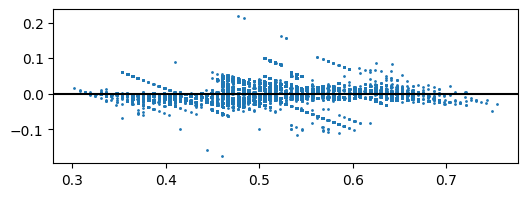

# Fold 0: R2=0.84589


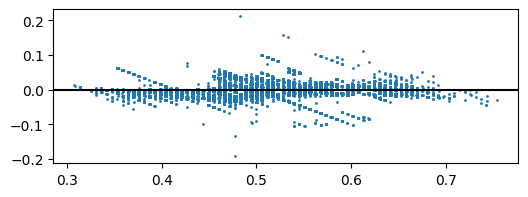

# Fold 1: R2=0.84494


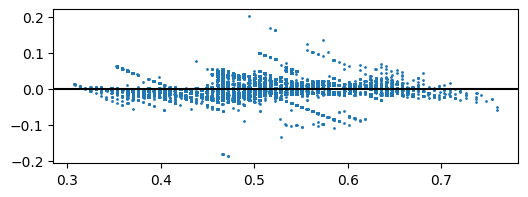

# Fold 2: R2=0.84481


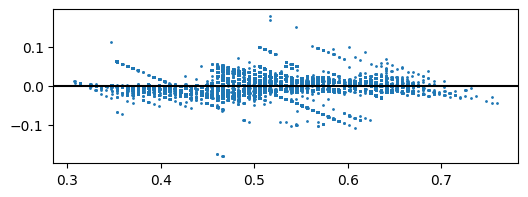

# Fold 3: R2=0.84442


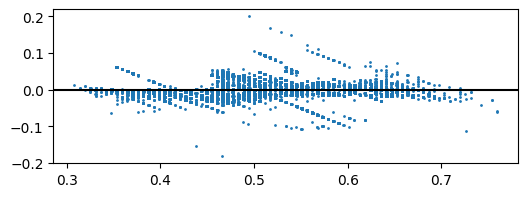

# Fold 4: R2=0.84465
# Overall: 0.84494 LinearRegression   0 min


In [52]:
model = make_pipeline(StandardScaler(),
                      LinearRegression())
cross_validate(model, 'LinearRegression')

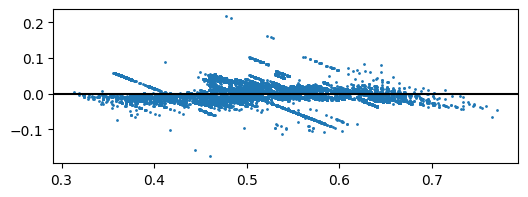

# Fold 0: R2=0.84642


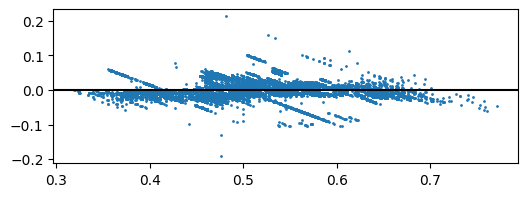

# Fold 1: R2=0.84557


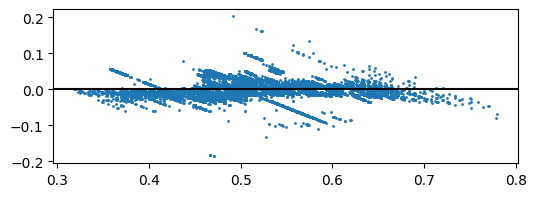

# Fold 2: R2=0.84531


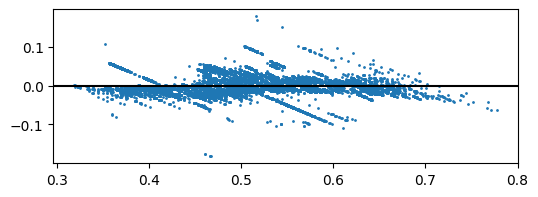

# Fold 3: R2=0.84500


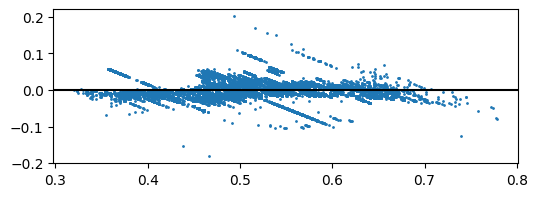

# Fold 4: R2=0.84517
# Overall: 0.84549 Poly-Ridge   1 min


In [53]:
# 多项式特征，尝试捕获非线性关系，但是高维数据下特征数较多，容易过拟合
model = make_pipeline(StandardScaler(),
                      PolynomialFeatures(degree=2),
                      Ridge())
cross_validate(model, 'Poly-Ridge')

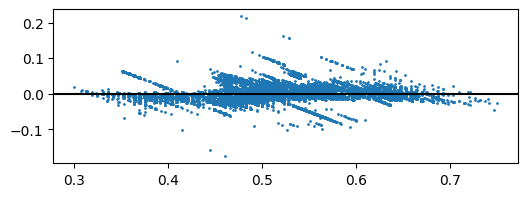

# Fold 0: R2=0.84627


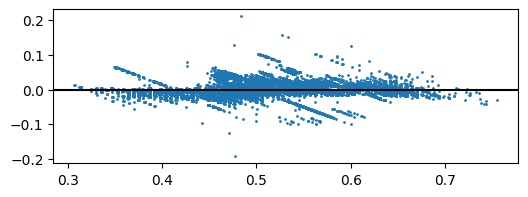

# Fold 1: R2=0.84536


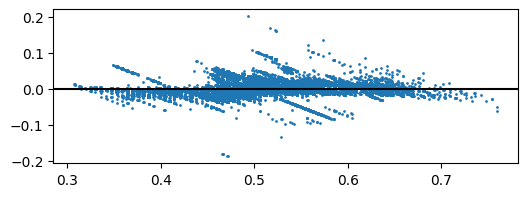

# Fold 2: R2=0.84515


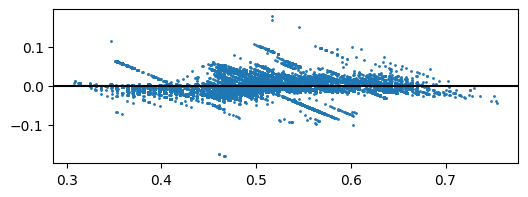

# Fold 3: R2=0.84473


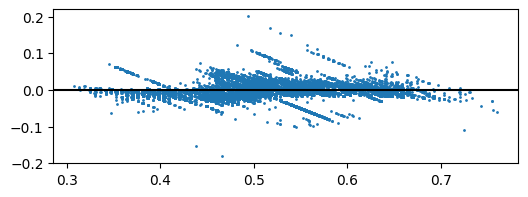

# Fold 4: R2=0.84498
# Overall: 0.84530 Spline-Ridge   0 min


In [54]:
# 样条变换，对局部非线性拟合能力强，但是对超参数较敏感
model = make_pipeline(StandardScaler(),
                      SplineTransformer(),
                      Ridge())
cross_validate(model, 'Spline-Ridge')

In [56]:
# As an alternative to scikit-learn's LinearRegression, we can use the statsmodels implementation. It shows us the regression coefficients with their pvalues
X = sm.add_constant(train[initial_features])
res = sm.OLS(train.FloodProbability, X, missing='error').fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       FloodProbability   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                 3.046e+05
Date:                Tue, 07 Oct 2025   Prob (F-statistic):               0.00
Time:                        21:57:07   Log-Likelihood:             2.7820e+06
No. Observations:             1117957   AIC:                        -5.564e+06
Df Residuals:                 1117936   BIC:                        -5.564e+06
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.0533      0.000   -234.995      0.000      -0.054      -0.053
MonsoonIntensity                    0.0056   9.25e-06    606.734      0.000       0.006       0.006
TopographyDrainage                  0.0056   9.09e-06    621.525      0.000       0.006       0.006
RiverManagement                     0.0057   9.18e-06    617.178      0.000       0.006       0.006
Deforestation                       0.0057   9.27e-06    612.404      0.000       0.006       0.006
Urbanization                        0.0057   9.14e-06    619.319      0.000       0.006       0.006
ClimateChange                       0.0057   9.25e-06    612.437      0.000       0.006       0.006
DamsQuality                         0.0057   9.13e-06    619.170      0.000       0.006       0.006
Siltation                           0.0056   9.21e-06    612.284      0.000       0.006       0.006
AgriculturalPractices               0.0056    9.2e-06    612.643      0.000       0.006       0.006
Encroachments                       0.0056   9.14e-06    618.374      0.000       0.006       0.006
IneffectiveDisasterPreparedness     0.0056   9.16e-06    615.995      0.000       0.006       0.006
DrainageSystems                     0.0056   9.18e-06    613.641      0.000       0.006       0.006
CoastalVulnerability                0.0057   9.11e-06    622.228      0.000       0.006       0.006
Landslides                          0.0056   9.15e-06    616.245      0.000       0.006       0.006
Watersheds                          0.0056   9.14e-06    617.853      0.000       0.006       0.006
DeterioratingInfrastructure         0.0056   9.21e-06    609.647      0.000       0.006       0.006
PopulationScore                     0.0057   9.17e-06    618.914      0.000       0.006       0.006
WetlandLoss                         0.0056    9.2e-06    612.654      0.000       0.006       0.006
InadequatePlanning                  0.0056   9.14e-06    613.363      0.000       0.006       0.006
PoliticalFactors                    0.0056    9.1e-06    620.512      0.000       0.006       0.006
==============================================================================
Omnibus:                   100155.250   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           148528.907
Skew:                           0.703   Prob(JB):                         0.00
Kurtosis:                       4.100   Cond. No.                         265.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
r2_score(train.FloodProbability, (train[initial_features].sum(axis=1) * 0.0056) - 0.05)

In [ ]:
# When I plotted the histogram of the target values above, I wrote that the histogram looks like a normal distribution. We now have the explanation: If you add twenty independent random variables, it's normal that you get a normal distribution (pun intended).
# NOTE: Below method and tree-based methods crash my PC, due to OOM error
# Nystroem transformer + Ridge
model = make_pipeline(StandardScaler(),
                      Nystroem(n_components=600),
                      Ridge())
cross_validate(model, 'Nystroem-Ridge')

In [ ]:
# Tree-based models

# ExtraTreesRegressor
model = ExtraTreesRegressor(n_estimators=100, min_samples_leaf=1)
cross_validate(model, 'ET')

In [ ]:
# XGBoost
xgb_params = {'grow_policy': 'depthwise', 'n_estimators': 100, 'learning_rate': 0.2639887908316703, 'max_depth': 10, 'reg_lambda': 62.46661785864016, 'min_child_weight': 0.33652299514909034, 'colsample_bytree': 0.2319730052165745, 'objective': 'reg:squarederror', 'tree_method': 'hist', 'max_bin': 2048, 'gamma': 0} # 0.83868
model = xgboost.XGBRegressor(**xgb_params)
cross_validate(model, 'XGBoost')

In [ ]:
# catBoost
model = catboost.CatBoostRegressor(verbose=False)
cross_validate(model, 'CatBoost')

In [ ]:
# LightGBM
model = lightgbm.LGBMRegressor(verbose=-1)
cross_validate(model, 'LightGBM')

In [ ]:
# Advanced models with feature engineering
temp = train.FloodProbability.groupby(train[initial_features].sum(axis=1)).mean()
plt.scatter(temp.index, temp, s=1, c=(temp.index.isin(np.arange(72, 76))), cmap='coolwarm')
plt.xlabel('sum of twenty initial features')
plt.ylabel('mean flood probability')
plt.show()

In [ ]:
# Add the special1 and fsum features
for df in [train, test]:
    df['fsum'] = df[initial_features].sum(axis=1) # for tree models
    df['special1'] = df['fsum'].isin(np.arange(72, 76)) # for linear models

# Add the special1 and fsum features
for df in [train, test]:
    df['fsum'] = df[initial_features].sum(axis=1) # for tree models
    df['special1'] = df['fsum'].isin(np.arange(72, 76)) # for linear models


In [ ]:
model = make_pipeline(StandardScaler(),
                      LinearRegression())
cross_validate(model, 'LinearRegression special1', features=initial_features+['special1'])

In [ ]:
model = make_pipeline(OneHotEncoder(categories=[np.unique(train.fsum)],
                                    drop='first', sparse_output=False),
                      StandardScaler(),
                      Ridge())
cross_validate(model, 'Ridge one-hot fsum', features=['fsum'])